# Predicting Bike-Sharing Patterns with a Neural Network

Learning the theory of neural networks is fun! With lots of derivatives flying around, a mathematically inclined people love neural networks and even take the extra steps to solve it by hand. Even though playing with neural works is fun, the fun actually starts when you apply it to real world data! In this notebook, I will walk you through my implementation of a neural network to predict bike-sharing patterns. This could be really useful for businesses in Netherland let's say. Your intuition must tell you that bikes are usually shared during holidays, during summers, and basically anytime that weather is nice and people are on holidays. Let's see whether these assumptions hold with some simple machine learning and data analysis.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Just like for all data science tasks, let's import our libraries. Those would be numpy for matrix manipulation, pandas for feature engineering, and pyplot for visualizations.

In [2]:
path = "Bike-Sharing-Dataset/hour.csv"
bike_rides = pd.read_csv(path)

In [3]:
# Let's visualize the first 10 data entries in the dataset
bike_rides.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In this data, `cnt` column registers all bike rides recorded in that day. Let's test our basic assumption first. Is it correct that summer months register more bike shares than the winter months. We could do this with a basic analysis on gathering summing up cnt for summer months and comparing it to winter months.

In [4]:
# Gather all rows that are in either summer or winter and record in their individual variables
winter_months, summer_months = [12, 1, 2], [6,7,8]
winter_data = bike_rides[bike_rides["mnth"].isin(winter_months)]
summer_data = bike_rides[bike_rides["mnth"].isin(summer_months)]

# Take the average of summer and winter_months
summer_avg = sum(summer_data["cnt"]) / float(summer_data.shape[0])
winter_avg = sum(winter_data["cnt"]) / float(winter_data.shape[0])

# Print the summer and winter averages
print("Summer average of daily bike sharing is {0} versus winter average of daily bike sharing is {1}"\
      .format(summer_avg, winter_avg))

Summer average of daily bike sharing is 236.76674994322053 versus winter average of daily bike sharing is 116.9341641194451


Wow! The summer average of daily bike sharing is twice of the winter average of daily bike sharing. Our intuition was correct. We also learned something else about this data as well. It's very high likely that these data points were collected in the northern hemisphere. But you must be asking yourself are seasons the only factor that affect bike sharing. The answer is probably incorrect. To understand why it is, let's look at the first week of the given data.

<AxesSubplot:xlabel='dteday'>

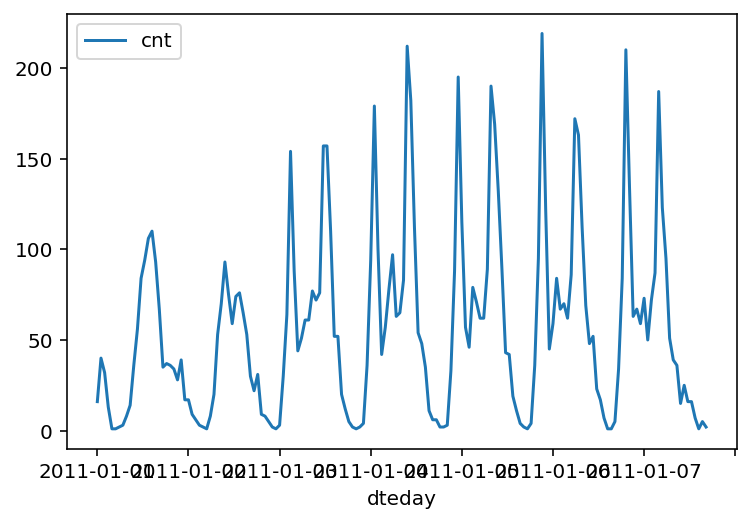

In [5]:
bike_rides[:24*7].plot(x="dteday", y="cnt")

Seeing this piece of data, it's easy to see that there are spikes of bike sharing within a week. For example, it must be the case that people are using bike share when they are biking to and from work. And there must be other factors that you can't even infer from just looking at data. For that reason, we develop a neural network from scratch to predict these patterns!

## Feature Engineering

### Dummy Variables

Our first task is to identify columns that are categorical. Just by looking at data, columns `season`, `yr`, `mnth`, `hr`, `weekday`, `weathersit` are all categorical variables that we could build dummy variables from. We will be using Pandas `get_dummies()` function to do so.

In [6]:
dummy_fields = ["season", "yr", "weathersit", "mnth", "hr", "weekday"]
for var in dummy_fields:
    # Get dummy variables for the given dummy field
    dummies = pd.get_dummies(bike_rides[var], prefix=var, drop_first=False)
    # Concatenate to the bike_rides data (we will drop the dummy fields right after)
    bike_rides = pd.concat([bike_rides, dummies], axis=1)

Some columns are useless now. For example, those that we created dummy fields from are no longer needed. In addition, columns like `dteday` give us no information at all. 

In [7]:
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr', "yr"]

data = bike_rides.drop(fields_to_drop, axis=1)
data.head()

,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0.24,0.81,0.0,3,13,16,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.22,0.80,0.0,8,32,40,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.22,0.80,0.0,5,27,32,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.24,0.75,0.0,3,10,13,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.24,0.75,0.0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Standardize Continuous Variables

To make sure that training works, we will also need to make sure that we standardize each continuous variables. Standardization means that they have a mean of 0 and standard deviation of 1.

In [8]:
continuous_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so that we can convert those back
scaled_features = {}
for f in continuous_features:
    mean, std = data[f].mean(), data[f].std()
    scaled_features[f] = [mean, std]
    data.loc[:, f] = (data[f] - mean) / std

### Splitting Data into Train, Test & Validation

One of the fundamental architectures to build a working neural network is to split the data into train, test, and validation sets. We will use a test size of 21 days to understand whether our data is working. Instead of just looking at `cnt`, we will be looking at three different fields as target variables `cnt`, `casual`, and `registered`. 

In [9]:
# Save the test data
test_data = data[-21*24:]

# Remove the test data from the data set
data = data[:-21*24]

# Separate the data into features and targets
targets = ['cnt', 'casual', 'registered']
features, targets = data.drop(targets, axis=1), data[targets]
test_features, test_targets = test_data.drop(targets, axis=1), test_data[targets]

# Hold out the last 60 days or so of the remaining data as a validation set
train_features , train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Building the Neural Network

In this portion, we will implement the forward and backward pass for one hidden layer neural network. For this exercise, we will use the notorious sigmoid function for the activation of the hidden layer and $f(x) = x$ function.

In [10]:
import numpy as np

class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights with normal distributions
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        
        # Set the learning rate
        self.lr = learning_rate
        
        # Define the activation function (sigmoid function)
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implement the forward pass function below
            # Implement the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implements forward pass
         
            Arguments
            ---------
            X: features batch

        '''
        # Forward pass, which is basically making a prediction                    
        hidden_inputs = np.dot(X, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs                   
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implements backpropagation        
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        # Calculate the output error
        error = y - final_outputs
        
        # Calculate the output error term
        output_error_term = error
        

        # Calculate hidden error
        hidden_error = self.weights_hidden_to_output.dot(output_error_term)
        
        # Calculate the hidden layer's contribution to the error
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:, None]
        # Weight step (hidden to output)
        delta_weights_h_o += (output_error_term * hidden_outputs)[:, None]
        return delta_weights_i_h, delta_weights_h_o 

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        # Updates weights according to gradient descent
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        # Runs forward pass to make a prediction
        hidden_inputs = np.dot(features,self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs


#########################################################
# Hyperparameter Tuning
##########################################################
iterations = 2200
learning_rate = 1.0
hidden_nodes = 12
output_nodes = 1

In [11]:
def MSE(y, Y):
    """
    Calculates MSE Error
    
    Arguments
    ---------
    y: prediction
    Y: real label values
    """
    return np.mean((y-Y)**2)

### Unit tests

Just for good practice, we will run unit tests to see the correctness of our network. These will make sure that the neural network is working properly.

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(bike_rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        
        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.004s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## The Art of Training a Neural Network

After you built your neural network architecture, now it is the time to explore how your model performs with different parameters. This is where the fun comes in. By playing with different parameters, we see whether we could get the best performance possible. Be careful though. Your model could be performing really really well on your training data, but that is not the only behavior we want to see. We also want to validate our model, with another dataset called validation set. Therefore, we would like to stop training where our validation errors starts to increase after decreasing. At the end, we should have the most general model possible.

We will be using the method called the Stochastic Gradient Descent to train our network. For each training pass, we will use a random sample of data to train our model. For this model, we will be playing with different number of iterations, learning rate, number of hidden nodes. The set of hyperparameters we defined above are performing really well for this task, but you could also try to play with them to see whether you could get a better model!

In [14]:
import sys

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.061 ... Validation loss: 0.144

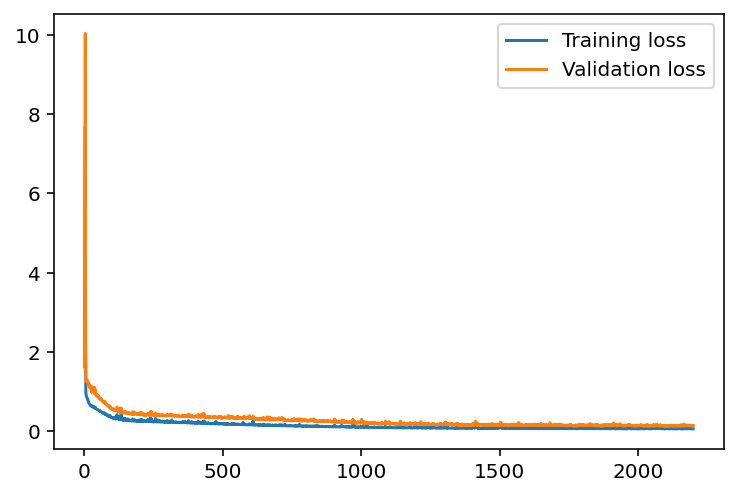

In [15]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

We see that the loss values drop below the desired thresholds. Now, let's see how we do by actually making predictions with the model.

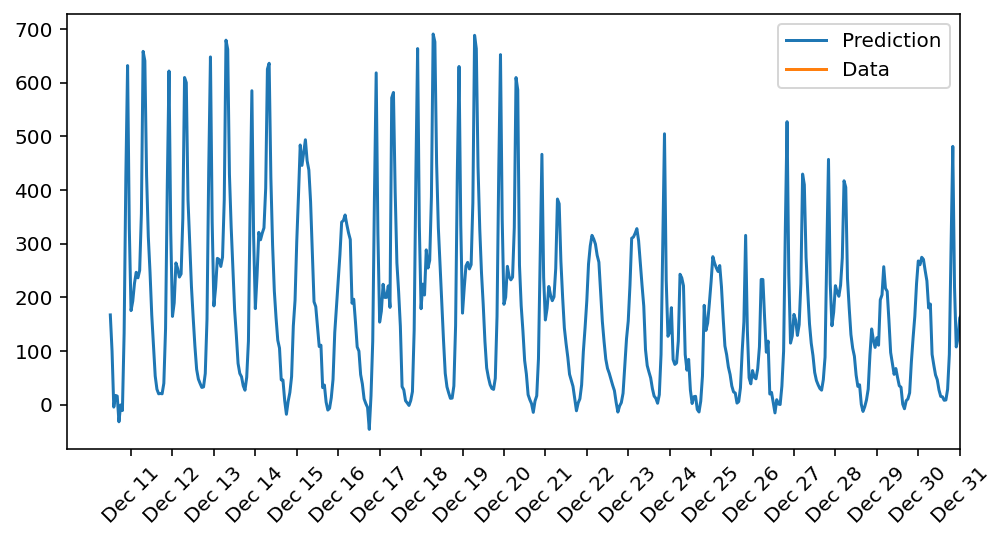

In [17]:
# Time to c
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(bike_rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## What's Next?

I'd also like to close a project with some thoughts at the end as to how I could improve or built upon this idea. A useful approach to this could be actually getting real world data from Santander Bikes in London. Being able to compare patterns from this year 